# [IAPR 2019:][iapr2019] Lab 3 ‒  Classification

**Author:** first name and last name

**Due date:** 10.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import scipy.io

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)
    
data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

*Add your implementation and discussion*

In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [6]:
# Explore the data
pca = PCA(n_components = 1)

In [8]:
projected_x = pca.fit_transform(a)

min_value = min(projected_x)

max_value = max(projected_x)

In [19]:
# Discretize data
bins = np.linspace(min_value, max_value, 20)

inds = np.digitize(projected_x.reshape(-1), \
                  bins)

In [22]:
indices, count = np.unique(inds, return_counts = True)

<BarContainer object of 17 artists>

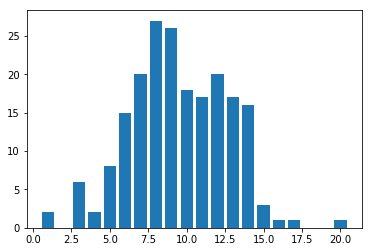

In [23]:
plt.bar(indices, count)

First trial: Assume the Covirance matrix is diagonal

In [ ]:
# Compute covariance matrix

### 1.2 Mahalanobis distance
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

*Add your implementation and discussion*

## Part 2

In this part, we aim to classify digits using the complete version of MNIST digits dataset. The dataset consists of 60'000 training images and 10'000 test images of handwritten digits. Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value. Given this data, your task is to construct a Multilayer Perceptron (MLP) by Tensorflow framework and evaluate it on MNIST the test images.

To facilitate your task, we will walk you through the required steps by a simple tutorial. By finishing this part, you learn the basic workflow of using TensorFlow with a simple linear model and multilayer perceptron (MLP) model, respectively.

As the starting point, we aim to work with MNIST dataset. After loading the dataset, we define and optimize a simple mathematical model in TensorFlow. The results are then plotted and discussed. First, we import tensorflow with other needed packages. If Tensorflow is not installed on your computer, you can install it by running `pip install --upgrade tensorflow` command in your terminal, after activating your enviroment.

In [ ]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import gzip
from sklearn.metrics import confusion_matrix

You can figure out your tensorflow version by running the following command:

In [ ]:
tf.__version__

### Load Data

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under lab-03-data/part2. You can then use the script provided below to extract and load training and testing images in Python.

In [ ]:
def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [ ]:
# Display the openend files
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

print("Training Set ", train_images.shape, train_labels.shape)
print("Test Set", test_images.shape, test_labels.shape)

The MNIST dataset has now been loaded and consists of images and associated labels (i.e. classifications of the images). The dataset is split into 2 mutually exclusive sub-sets (60000 training images and 10000 test images, respectively). You can display the images in each sub-set. They should match the labels.

### Helper-function for plotting images

We define a function to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image. Then we plot a few images with their labels, to see if data is loaded correctly.

In [ ]:
image_size = 28

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(image_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Get the first images from the test-set.
images = test_images[0:9]

# Get the true classes for those images.
cls_true = test_labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### One-Hot Encoding and Image Flattened Mode

Our labels contain a list of predictions for our examples, e.g. [1, 9, ...]. In tensorflow, the label has to be converted to the encoding format as so-called One-Hot encoding. This means the labels have been converted from a single number to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i$'th element which is one and means the class is $i$.

In addition, because we are going to use linear layers and multiplications of the neural network, you always want your data to be a (1 or) 2-dimensional matrix, where each row is the vector representing your data. Therefore, it would be more complicated and less efficient without reshaping images first. Here, we need to flatten images before passing them to our model. As an example, please print out the One-Hot encoded labels for the first 5 images in the test set.

In [ ]:
def reformat(dataset, labels):
    """
        Reformat the data to the one-hot and flattened mode
    """
    n_dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)

    # Convert to the one hot format
    n_labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)

    return n_dataset, n_labels


num_labels = 10

train_images, train_labels = reformat(train_images, train_labels)
test_images, test_labels = reformat(test_images, test_labels)

# Display the files
print("Training Set - shape: ", train_images.shape, train_labels.shape)
print("Test Set - shape: ", test_images.shape, test_labels.shape)
print("Test Set labels - [1 to 5]: \n", test_labels[0:5,:])

### TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can automatically calculate the gradients that are needed to optimize the variables of the graph to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain rule for derivatives.


A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used to change the input to the graph.
* Model variables that are going to be optimised to make the model perform better.
* The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables of the model.

In addition, the TensorFlow graph may also contain various debugging statements, e.g. for logging data to be displayed using TensorBoard, which is not covered here.

### Default graph

As the starting point, we create a new computational graph via the `tf.Graph` constructor. To add operations to this graph, we must register it as the default graph. The way the TensorFlow API is designed, library routines that create new operation nodes always attach these to the current default graph. We register our graph as the default by using it as a Python context manager in a `with-as` statement.

### Placeholder variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First, we define the placeholder variable for the input images including train and validation set. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to `float32` and the shape is set to `[None, image_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being reshaped into a vector of length `image_size_flat` which is equal to image_size * image_size. In addition, we create a constant tensor for the validation and test set since they are fixed and will be evaluated later.   

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `TF_TRAIN_DATASET`. The shape of this placeholder variable is `[None, num_labels]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_labels` which is 10 in this case.

### Variables to be optimized

Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow to make the model perform better on the training data.

In fact, the model variables are the network hidden layer parameters including layer's weights and biases. The first variable that must be optimized are `WEIGHTS` and defined here as a TensorFlow variable that must be initialized and whose shape is `[image_size_flat, num_labels]` for the simple linear model, so it is a 2-dimensional tensor (or matrix) with `image_size_flat` rows and `num_labels` columns. There are various ways to initialize the weights like initialization with zeros `tf.zeros`, `tf.truncated_normal` and `tf.random_normal`, which output random values from a normal distribution and you can specify the mean and The standard deviation (`stddev`) of the normal distribution.

The second variable that must be optimized is called `BIASES` and is defined as a 1-dimensional tensor (or vector) of length `num_labels`.

Last but not least, you should name every important operation in your code. In complex models, it is good practice to use `scopes`. The important point is that if you want to later use some operation, you have to either name it or put it into a collection.

### Model

This simple mathematical model multiplies the training images in the placeholder variable `TF_TRAIN_DATASET` with the `WEIGHTS` and then adds the ` BIASES`. The result is a matrix of shape `[num_images, num_labels]` because `TF_TRAIN_DATASET` has shape `[num_images, image_size_flat]` and `WEIGHTS` has shape `[image_size_flat, num_labels]`, so the multiplication of those two matrices is a matrix with shape `[num_images, num_labels]` and then the `BIASES` vector is added to each row of that matrix.

However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the `LOGITS` matrices sums to one (see below code), and each element is limited between zero and one. This is calculated using the so-called softmax function `tf.nn.softmax`.

### Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for `WEIGHTS` and `BIASES`. To do this, we first need to know how well the model currently performs by comparing the predicted output of the model to the desired output.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is, therefore, to minimise the cross-entropy, so it gets as close to zero as possible by changing the `WEIGHTS` and `BIASES` of the model.

TensorFlow has a built-in function for calculating the cross-entropy using `tf.nn.softmax_cross_entropy_with_logits`. Note that it uses the values of the `LOGITS` in train, validation and test sets because it also calculates the softmax internally. In order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy using (`tf.reduce_mean`) for all the image classifications.

### Optimization method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the basic form of Gradient Descent where the step-size is set to 0.5.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [ ]:
image_size_flat=image_size * image_size

# Create a new graph
GRAPH = tf.Graph()

# Register the graph as the default one to add nodes
with GRAPH.as_default():
    
    # Define placeholders
    TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, image_size * image_size))
    TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, num_labels))
    TF_TEST_DATASET = tf.constant(test_images)
    
    with tf.name_scope("Linear_model"):
        
        """
           Initialize weights and biases
        """
        
        WEIGHTS = tf.Variable(tf.random_normal(shape=[image_size_flat, num_labels], stddev=0.1))
        BIASES = tf.Variable(tf.zeros([num_labels]))
    
        """
           Compute the logits WX + b
        """ 
        TRAIN_LOGITS = tf.matmul(TF_TRAIN_DATASET, WEIGHTS) + BIASES
        TEST_LOGITS = tf.matmul(TF_TEST_DATASET, WEIGHTS) + BIASES
    
        """
           Softmax function
        """   
        TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
        TEST_PREDICTION = tf.nn.softmax(TEST_LOGITS)
    
        """
           Cost-function
        """
        CROSS_ENTROPY= tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS)
        COST= tf.reduce_mean(CROSS_ENTROPY)
        # Optimizer
        OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(COST)

### Helper-functions to compute the accuracy

Now, we need a performance measure to display the progress to the user. This can be done via defining a function to compute accuracy to see whether the predicted class equals the true class of each image.

In [ ]:
def accuracy(predictions, labels):
    """
        Divides the number of true predictions to the number of total predictions
    """
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

### Create TensorFlow session and RUN!

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph and train our model. For this, we enter a session environment using a `tf.Session` as a context manager. We pass our graph  object to its constructor, so that it knows which graph to manage. To then execute nodes, we have several options. The   most general way is to call Session.run() and pass a list of tensors we wish to compute. Alternatively, we may call `eval()` on  tensors and `run()` on  operations directly.

Before evaluating any other node, we must first ensure that the variables in our graph are initialized. Theoretically,  we could `run` the `Variable.initializer` operation for each variable. However, one most often just uses the
`tf.initialize_all_variables()` utility operation provided by TensorFlow, which in turn executes the `initializer` 
operation for each `Variable` in the graph. Then, we can perform a certain number of iterations of stochastic gradient  descent, fetching an example and label from the MNIST dataset each time and feeding it to the run routine. 

One important point is that, there are many images in the training-set. Therefore, it takes a long time to calculate the gradient of the model using all these images. We therefore use Stochastic Gradient Descent which only uses a small batch of images in each iteration of the optimizer.

In [ ]:
batch_size = 100
num_iterations = 5000

In [ ]:

with tf.Session(graph=GRAPH) as session:
    """
        Start the above variable initialization
    """
    tf.initialize_all_variables().run()
    print("Variables initialized")

    for step in range(num_iterations):
        """
            Generate a random base and then generate a minibatch
        """
        BASE = (step * batch_size) % (train_labels.shape[0] - batch_size)
        BATCH_DATA = train_images[BASE:(BASE + batch_size), :]
        BATCH_LABELS = train_labels[BASE:(BASE + batch_size), :]
        """
            Feed the current session with batch data
        """
        FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS}
        _, l, predictions = session.run([OPTIMIZER, COST, TRAIN_PREDICTION], feed_dict=FEED_DICT)

        if(step % 500 == 0):
            print("Minibatch loss at step ", step, ": ", l)
            print("Minibatch accuracy: ", accuracy(predictions, BATCH_LABELS))
            
        if (step == num_iterations-1):
            print("Test accuracy: ", accuracy(TEST_PREDICTION.eval(), test_labels))

## Multilayer Perceptron (MLP)

The next architecture we are going to work with is multilayer perceptron (MLP). An MLP can be viewed as a logistic regression classifier where the input is first transformed using some non-linear transformations of the intermediate network layers. These intermediate layers are referred to as a `hidden layers`. Here, we are going to define TF graph for the MLP model with two hidden layers and one output layer. 

In addition, another milestone in the deep learning revolution, e.g. the techniques that now permit the routine development of very deep neural networks is adoptation of a rectified linear activation unit (Relu) that uses the rectifier function for the hidden layers. In tensorflow we use `tf.nn.relu` for Relu.

### Problem 1

In our example, the MLP model has two hidden layers with sizes of `hidden_nodes_1=1024` and `hidden_nodes_2=512`, respectively. In MLP, every element of a previous layer is connected to every element of the next layer. For example, the weights in the second hidden layer has `shape=[hidden_nodes_1, hidden_nodes_2]`. 

Now, lets define MLP graph:

In [ ]:
#Define the number of nodes for the hidden layers
hidden_nodes_1=1024
hidden_nodes_2=512

MLP_GRAPH = tf.Graph()

with MLP_GRAPH.as_default():
    """
        For the training data we use place holders in order to feed them
        in the run time with those mini bitches :D
    """
    TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, image_size * image_size))
    TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, num_labels))
    TF_TEST_DATASET = tf.constant(test_images)

    """
       The first hidden layer with 1024 nodes
    """
    
    with tf.name_scope("FirstHidden"):
        """
            Initialize the hidden weights and biases
        """
        HIDDEN_WEIGHTS_1=tf.Variable(tf.random_normal(shape=[image_size * image_size, hidden_nodes_1], stddev=0.1))
        HIDDEN_BIASES_1 =tf.Variable(tf.random_normal(shape=[hidden_nodes_1], stddev=0.1))

        """
            Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
            The relu is applied on the hidden layer nodes only
        """
        TRAIN_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(TF_TRAIN_DATASET, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)
        TEST_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(TF_TEST_DATASET, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)
        
    """
       The second hidden layer with 512 nodes
    """
    
    with tf.name_scope("SecondHidden"):
        
        #Add your code for implementation of the second layer here
        


    with tf.name_scope("Softmax-Linear"):
        """
            Initialize the main weights and biases
        """
        WEIGHTS=tf.Variable(tf.random_normal(shape=[hidden_nodes_2, num_labels], stddev=0.1))
        BIASES=tf.Variable(tf.random_normal(shape=[num_labels], stddev=0.1))

        """
            Compute the logits WX + b and the apply D(S(WX + b), L) on them for the final layer
        """
        TRAIN_LOGITS = tf.matmul(TRAIN_HIDDEN_LOGITS_2, WEIGHTS) + BIASES
        TEST_LOGITS = tf.matmul(TEST_HIDDEN_LOGITS_2, WEIGHTS) + BIASES

        LOSS = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS))

        OPTIMIZER = tf.train.GradientDescentOptimizer(0.0005).minimize(LOSS)
        tf.add_to_collection("activation", TRAIN_LOGITS)

        TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
        TEST_PREDICTION = tf.nn.softmax(TEST_LOGITS)

### Helper-function to perform optimization iterations

Here, we build a function for performing a number of optimization iterations so as to gradually improve the weights and biases of the MLP model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The inputs of the function are the number of iterations `num_iterations` and number of used samples `num_samples` to train the model

In [ ]:
def optimize(num_iterations, num_samples):
    
    with tf.Session(graph=MLP_GRAPH) as session:

        """
            Start the above variable initialization
        """
        tf.initialize_all_variables().run()
        print("Variables initialized")

        for step in range(num_iterations):
            """
                Select the desired samples
            """
            TRAIN_DATASET_S = train_images[:num_samples]
            TRAIN_LABELS_S = train_labels[:num_samples]
            """
                Generate a random base and then generate a minibatch
            """
            
            indices = np.random.choice(range(TRAIN_LABELS_S.shape[0]
                                             ), batch_size)
            BATCH_DATA = TRAIN_DATASET_S[indices, :]
            BATCH_LABELS = TRAIN_LABELS_S[indices, :]

            """
                Feed the current session with batch data
            """
            FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS}
            _, l, predictions = session.run([OPTIMIZER, LOSS, TRAIN_PREDICTION], feed_dict=FEED_DICT)

            if (step == num_iterations - 1):
                acc=accuracy(TEST_PREDICTION.eval(), test_labels)
                print("Test accuracy: ", accuracy(TEST_PREDICTION.eval(), test_labels))

    return acc

### Problem 2

Now, we want to train and compare the MLP model with two hidden-layers that we defined before using different number of training samples. You should use varying number of training samples including 5000, 10000 and 20000 images and report the MLP accuracy for each experiment. Please set `num_iterations` to 2000.

Hint: You can use `optimize` function. 

In [ ]:
TRAINING_SIZES = [5000, 10000, 20000]

#Add your code here
